Install [openslide-python](https://openslide.org/api/python/) libray

In [1]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [84.8 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.laun

Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import code from repository

In [3]:
!rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
!git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

Cloning into '/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 260 (delta 11), reused 26 (delta 11), pack-reused 234
Receiving objects: 100% (260/260), 49.29 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [26]:
ROOTDIR_SRC = "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP/src"
import os
import sys
import openslide
sys.path.append(ROOTDIR_SRC)
from wsi_utils import DatasetManager
from wsi_utils import get_heatmap
from utils import seaborn_cm
import matplotlib.pyplot as plt
from annotation_utils import get_annotation_mask, overlap
from wsi_utils import filt_tile_placeholders
from wsi_utils import get_heatmap
import matplotlib
from PIL import Image
import pickle
import numpy as np
import tensorflow as tf

# Segment WSIs

Load pre-predicted tiles

In [17]:
img_id = 2
downsample = 1/100
DIR_SLIDES = "/content/drive/MyDrive/Datasets/CRC_WSIs"
DIR_TILES = os.path.join(DIR_SLIDES, "CRC_WSIs_tiles")
img_fname = os.path.join(DIR_SLIDES, "{}.svs".format(img_id))
xml_fname = os.path.join(DIR_SLIDES, "{}.xml".format(img_id))
tiles_fname = os.path.join(DIR_TILES, "{}_tile_placeholders.pickle".format(img_id))
slide = openslide.OpenSlide(img_fname)
mask = get_annotation_mask(xml_fname, slide, downsample, "red")

Superimpose mask over the original slide

In [18]:
overlap_image = overlap(slide, mask, downsample)

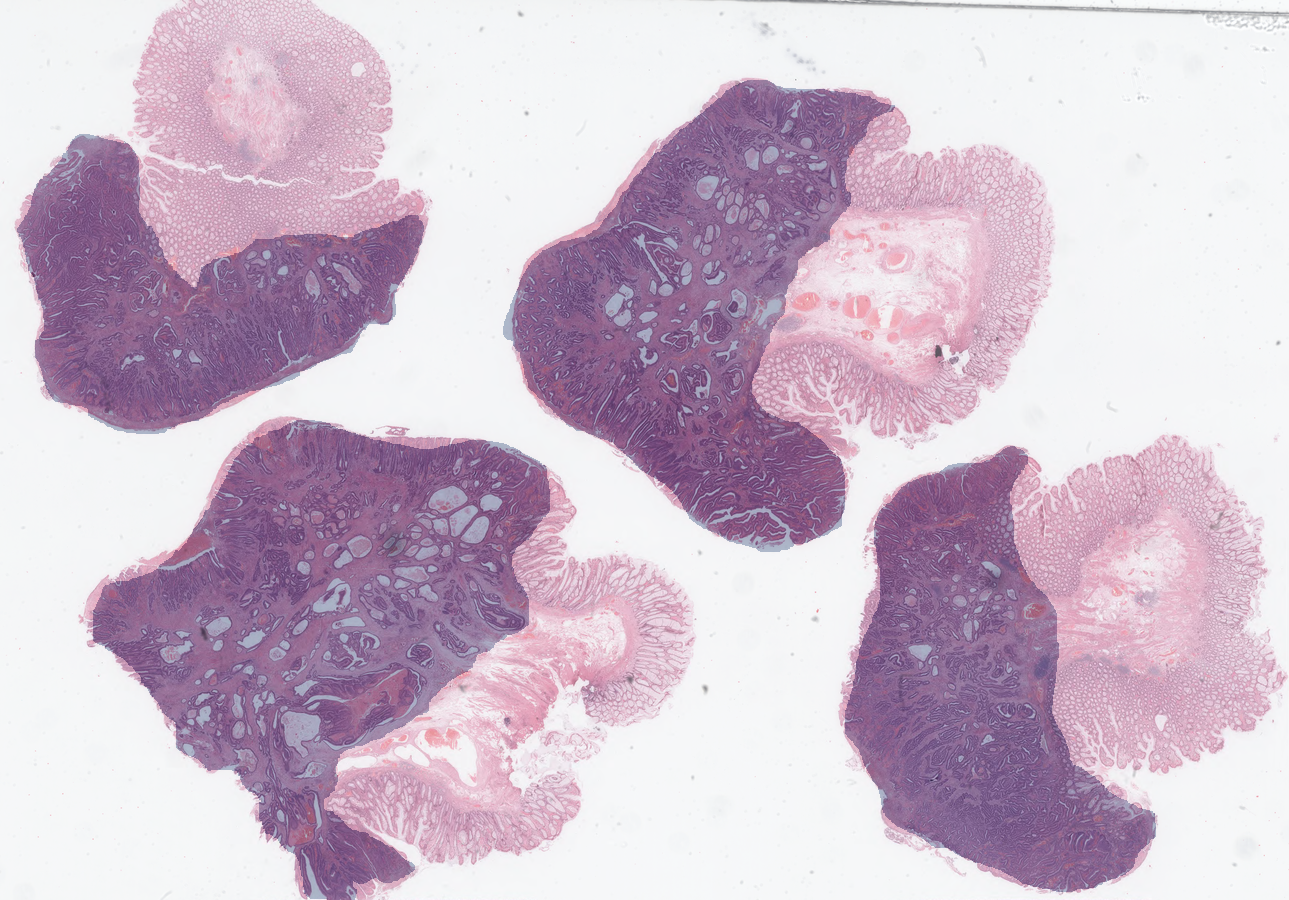

In [19]:
overlap_image

Load and show heatmap

In [21]:
with open(tiles_fname, "rb") as fp:
    tiles = pickle.load(fp)
heatmap_NH, segmentation = get_heatmap(tiles,
                                       slide,
                                       class_to_map=1,
                                       level_downsample=downsample,
                                       num_classes=2,
                                       threshold=0.5,
                                       colormap=matplotlib.cm.get_cmap('Reds'),
                                       tile_placeholders_mapping_key='prediction')

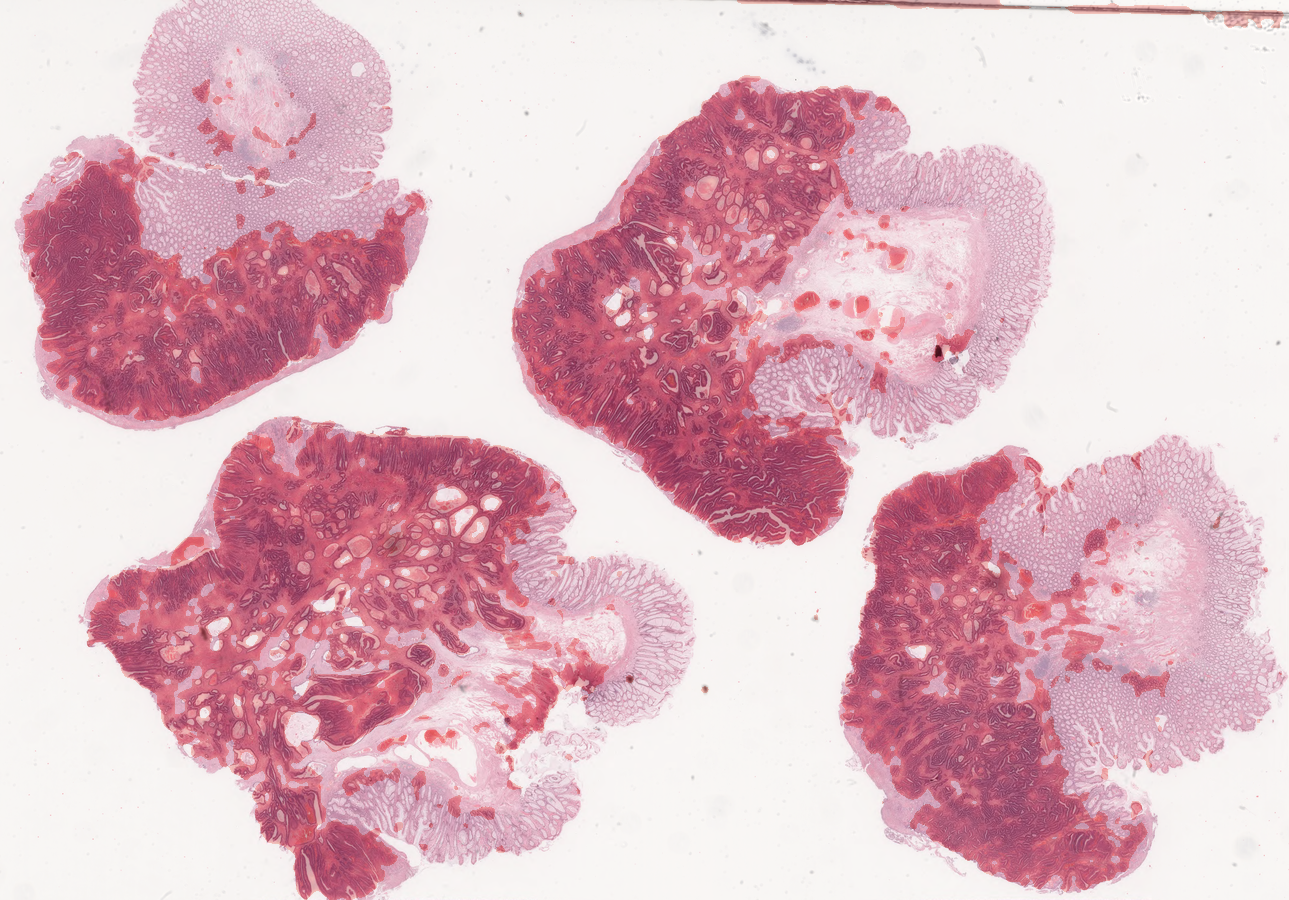

In [22]:
heatmap_NH

Compute IoU

In [27]:
segmentation[segmentation!=0] = 255
Image.fromarray(segmentation)
ground_thruth = np.ravel(mask)/255
preds = np.ravel(segmentation)/255
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(ground_thruth, preds)
print("IoU: {}".format(m.result().numpy()))

IoU: 0.8356909155845642
